In [3]:
import numpy as np
from scipy.stats import iqr
import dill
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import data_visualization as dv
import copy
import numba as nb
import time

import read_data_functions as rdf
import plot_functions as pf
from initializer import InitialThangs
from pathlib import Path
from Subject_Object_v3 import perc

np.set_printoptions(precision=3)


In [4]:
from Optimal_Stopping_Object import ModelConstructor,ModelFitting

%load_ext autoreload
%autoreload 2 

# Initial Thangs


In [5]:
plt.style.use("cashaback_dark")
wheel = dv.ColorWheel()

# SELECT EXPERIMENT
experiment = "Exp1"

# Get path and save path 
LOAD_PATH = Path(f"D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_{experiment}")
SAVE_PATH = f"D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{experiment}\\Figures\\"
it = InitialThangs(experiment)

# Pickle Data


In [6]:
# if 'group' not in locals():
group = rdf.generate_subject_object_v3(experiment,'Second Half')

# Create Model


Set inputs for model

In [7]:
if experiment == "Exp1":
    rt = np.nanmedian(np.nanmedian(group.movement_metrics.reaction_times, axis=1)) - 25
    rt_sd = np.nanmedian(np.nanstd(group.movement_metrics.reaction_times, axis=1))

elif experiment == "Exp2":
    rt = np.nanmedian(np.nanmedian(group.movement_metrics.exp2_react_guess_reaction_time_split('react','only'), axis=1)) - 30
    rt_sd = np.nanmedian(np.nanstd(group.movement_metrics.reaction_times, axis=2))

mt                   = np.min(np.nanmedian(np.nanmedian(group.movement_metrics.movement_times('task'), axis=2), axis=0)) # Get movement time for the condition where they tried the hardest
mt_sd                = np.nanmedian(np.nanstd(group.movement_metrics.movement_times('task'), axis=1))
time_sd              = np.array([np.nanmedian(np.nanstd(group.movement_metrics.coincidence_reach_time, axis=1))]*it.num_blocks)
perc_wins_both_reach = np.nanmean(group.score_metrics.wins_when_both_reach(perc=True), axis=0)
guess_sd             = np.nanmedian(np.nanstd(group.react_guess_movement_metrics.movement_onset_times('guess'), axis=2), axis=0)
agent_sds            = np.nanmean(np.nanstd(group.raw_data.agent_task_leave_time, axis=2), axis=0)[:,np.newaxis]
agent_means          = np.nanmean(np.nanmean(group.raw_data.agent_task_leave_time, axis=2), axis=0)[:,np.newaxis]
guess_leave_time_sd    = np.nanmedian(np.nanstd(group.react_guess_movement_metrics.movement_onset_times('guess'),axis=2),axis=0)

#* Set win, incorrect, indecision reward if messing around with beta parameters
win_reward = 1.0
indecision_cost = 0.0
incorrect_cost = 0.0


c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [8]:
free_params_init = {
                    'win_reward':1,
                    'incorrect_cost': 0,
                    'indecision_cost':0,
}

# targets = np.array(
#     [np.nanmedian(np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2),axis=0),
#     np.nanmedian(group.player_perc_wins,axis=0)/100,
#     np.nanmedian(group.player_perc_incorrects,axis=0)/100,
#     np.nanmedian(group.player_perc_indecisions,axis=0)/100,
#     ]
# )

# metric_keys = ['wtd_leave_time','prob_win','prob_incorrect','prob_indecision']
# group.predict_stopping_times(model_known_switch.inputs.guess_delay["true"])
behavior_targets = np.array(
    [
        np.nanmedian(np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2), axis=0),
        np.nanmedian(iqr(group.movement_metrics.movement_onset_times('task'), axis=2), axis=0),
    ]
)
behavior_metric_keys = ["wtd_leave_time","wtd_leave_time_iqr"]

# UNUSED, gonna use behavior metrics and watch the results fall out
results_targets = np.array([[np.nanmedian(group.score_metrics.score_metric('indecisions')/it.num_blocks, axis=0)]])
results_metric_keys = ["prob_indecision"]

### Alter the Incorrect Cost, Hold Indecision Constant

In [22]:
inc_incorrect_costs = [-1.00,-0.75,-0.50,-0.25,0.00,0.25,0.50,0.75,1.00]
win_rewards = [1]*len(inc_incorrect_costs)
inc_indecision_costs = list(np.array(inc_incorrect_costs)*-1)
incorrect_cost_models = []
incorrect_cost_model_labels = []
for win_reward,incorrect_cost,indecision_cost in zip(win_rewards,inc_incorrect_costs,inc_indecision_costs):
    temp_model = ModelConstructor(
        experiment=experiment,
        num_blocks=it.num_blocks,
        num_timesteps=1800,
        BETA_ON=False,
        agent_means=agent_means,
        agent_sds= agent_sds,
        reaction_time=np.array([rt, rt]),
        movement_time=np.array([mt, mt]),
        reaction_sd  =np.array([rt_sd, rt_sd]),
        movement_sd  =np.array([mt_sd, mt_sd]),
        timing_sd    =np.array([time_sd, time_sd]),
        perc_wins_when_both_reach=perc_wins_both_reach,
        guess_switch_delay=np.array([[70, 0]]).T, # Designed like this for broadcasting reasons
        guess_switch_sd=np.array([[25, 0]]).T,
        electromechanical_delay=np.array([[50, 50]]).T,
        switch_cost_exists=True,
        expected=False,
        win_reward=win_reward,
        incorrect_cost=incorrect_cost,
        indecision_cost=indecision_cost,
    )
    incorrect_cost_models.append(temp_model)
    incorrect_cost_model_labels.append(f"Wins: {win_reward}, Inc.: {incorrect_cost}, Ind.: {indecision_cost}")

### Alter the Indecision Cost, Hold Incorrect Constant

In [23]:
ind_indecision_costs = [-1.00,-0.75,-0.5,-0.25,0.00,0.25,0.50,0.75,1.00]
win_rewards = [1,1,1,1,1,1,1,1,1]*len(ind_indecision_costs)
ind_incorrect_costs = list(np.array(ind_indecision_costs)*-1)
indecision_cost_models = []
indecision_cost_model_labels = []
for win_reward,incorrect_cost,indecision_cost in zip(win_rewards,ind_incorrect_costs,ind_indecision_costs):
    temp_model = ModelConstructor(
        experiment=experiment,
        num_blocks=it.num_blocks,
        num_timesteps=1800,
        BETA_ON=False,
        agent_means=agent_means,
        agent_sds= agent_sds,
        reaction_time=np.array([rt, rt]),
        movement_time=np.array([mt, mt]),
        reaction_sd  =np.array([rt_sd, rt_sd]),
        movement_sd  =np.array([mt_sd, mt_sd]),
        timing_sd    =np.array([time_sd, time_sd]),
        perc_wins_when_both_reach=perc_wins_both_reach,
        guess_switch_delay=np.array([[70, 0]]).T, # Designed like this for broadcasting reasons
        guess_switch_sd=np.array([[25, 0]]).T,
        electromechanical_delay=np.array([[50, 50]]).T,
        switch_cost_exists=True,
        expected=False,
        win_reward=win_reward,
        incorrect_cost=incorrect_cost,
        indecision_cost=indecision_cost,
    )
    indecision_cost_models.append(temp_model)
    indecision_cost_model_labels.append(f"Wins: {win_reward}, Inc.: {incorrect_cost}, Ind.: {indecision_cost}")

# Plots

In [24]:
save = False, 
bw = 0.75

In [25]:
def generate_colormap(base_colors_hex, num_colors):
    num_colors+=1
    base_colors_rgb = [tuple(int(hex_color[i:i+2], 16) for i in (1, 3, 5)) for hex_color in base_colors_hex]
    colormap_rgb = []
    
    for i in range(num_colors-1):
        fraction = i / (num_colors - 1)
        base_color_index = int(fraction * (len(base_colors_rgb) - 1))
        
        color1 = base_colors_rgb[base_color_index]
        color2 = base_colors_rgb[base_color_index + 1]
        
        interpolated_color = [
            int(color1[j] * (1 - fraction) + color2[j] * fraction)
            for j in range(3)
        ]
        
        colormap_rgb.append(interpolated_color)
    
    colormap_hex = ['#{:02X}{:02X}{:02X}'.format(*rgb) for rgb in colormap_rgb]
    return colormap_hex

# Example usage
base_colors_hex = ['#FF0000', '#00FF00', '#0000FF']  # Red, Green, Blue
num_colors = 10
colormap_hex = generate_colormap(base_colors_hex, num_colors)

LEave Target Time


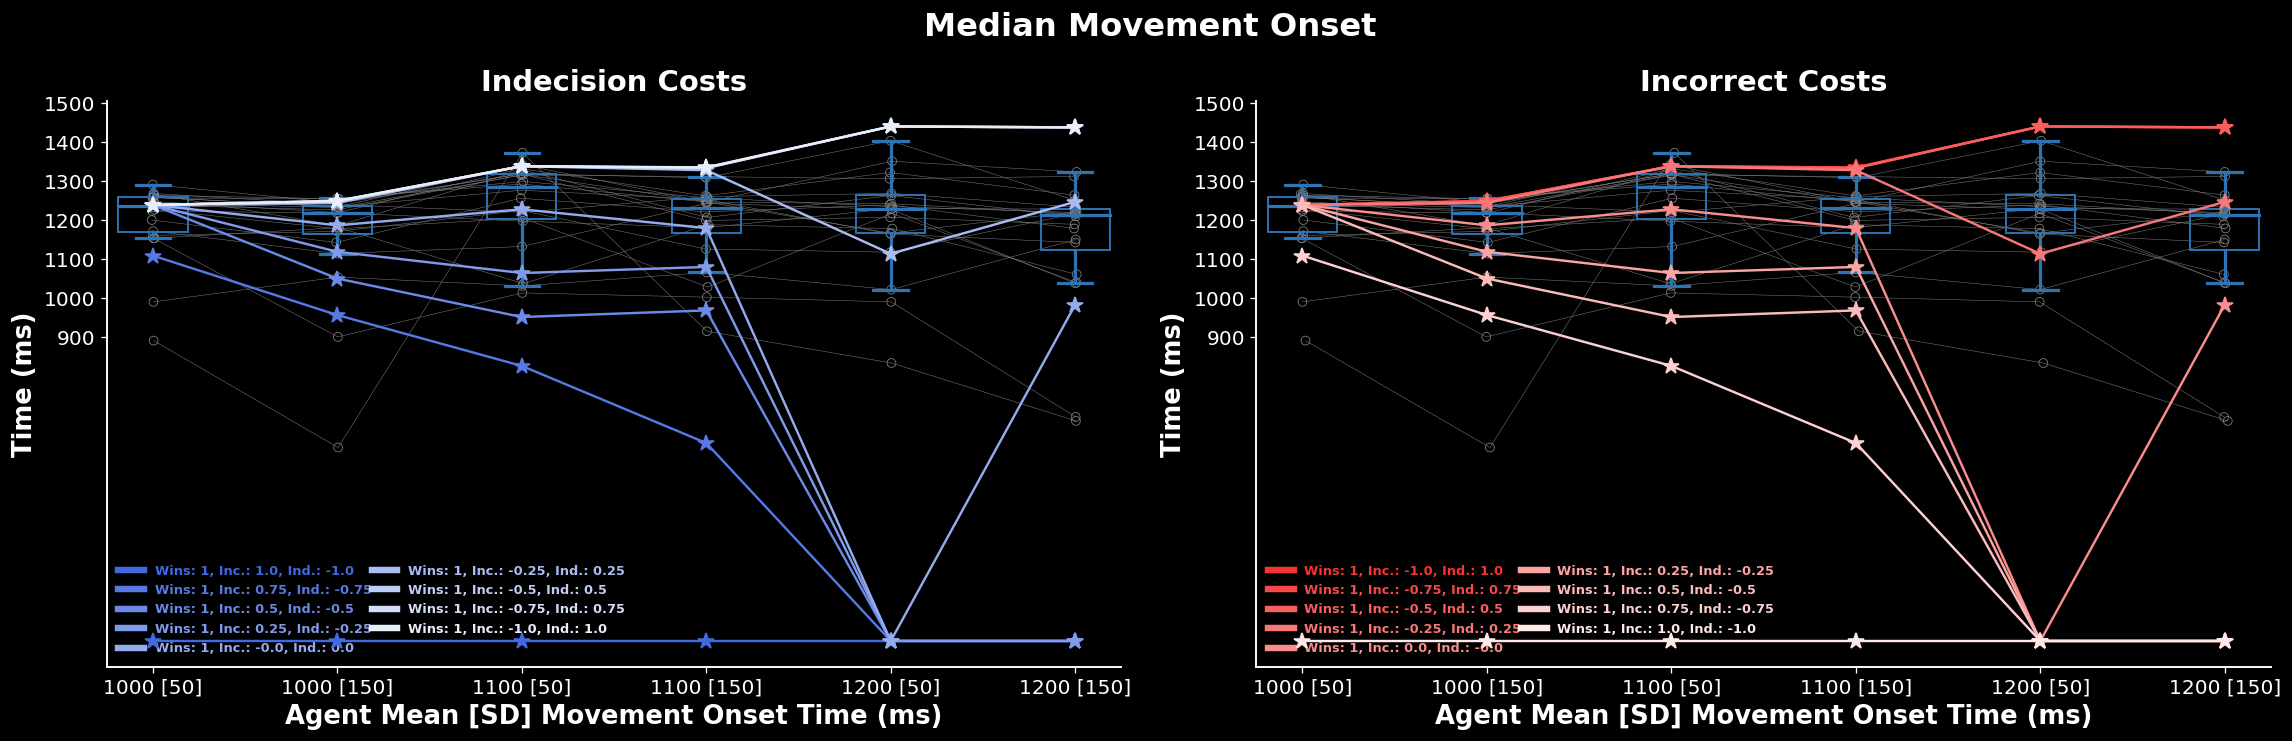

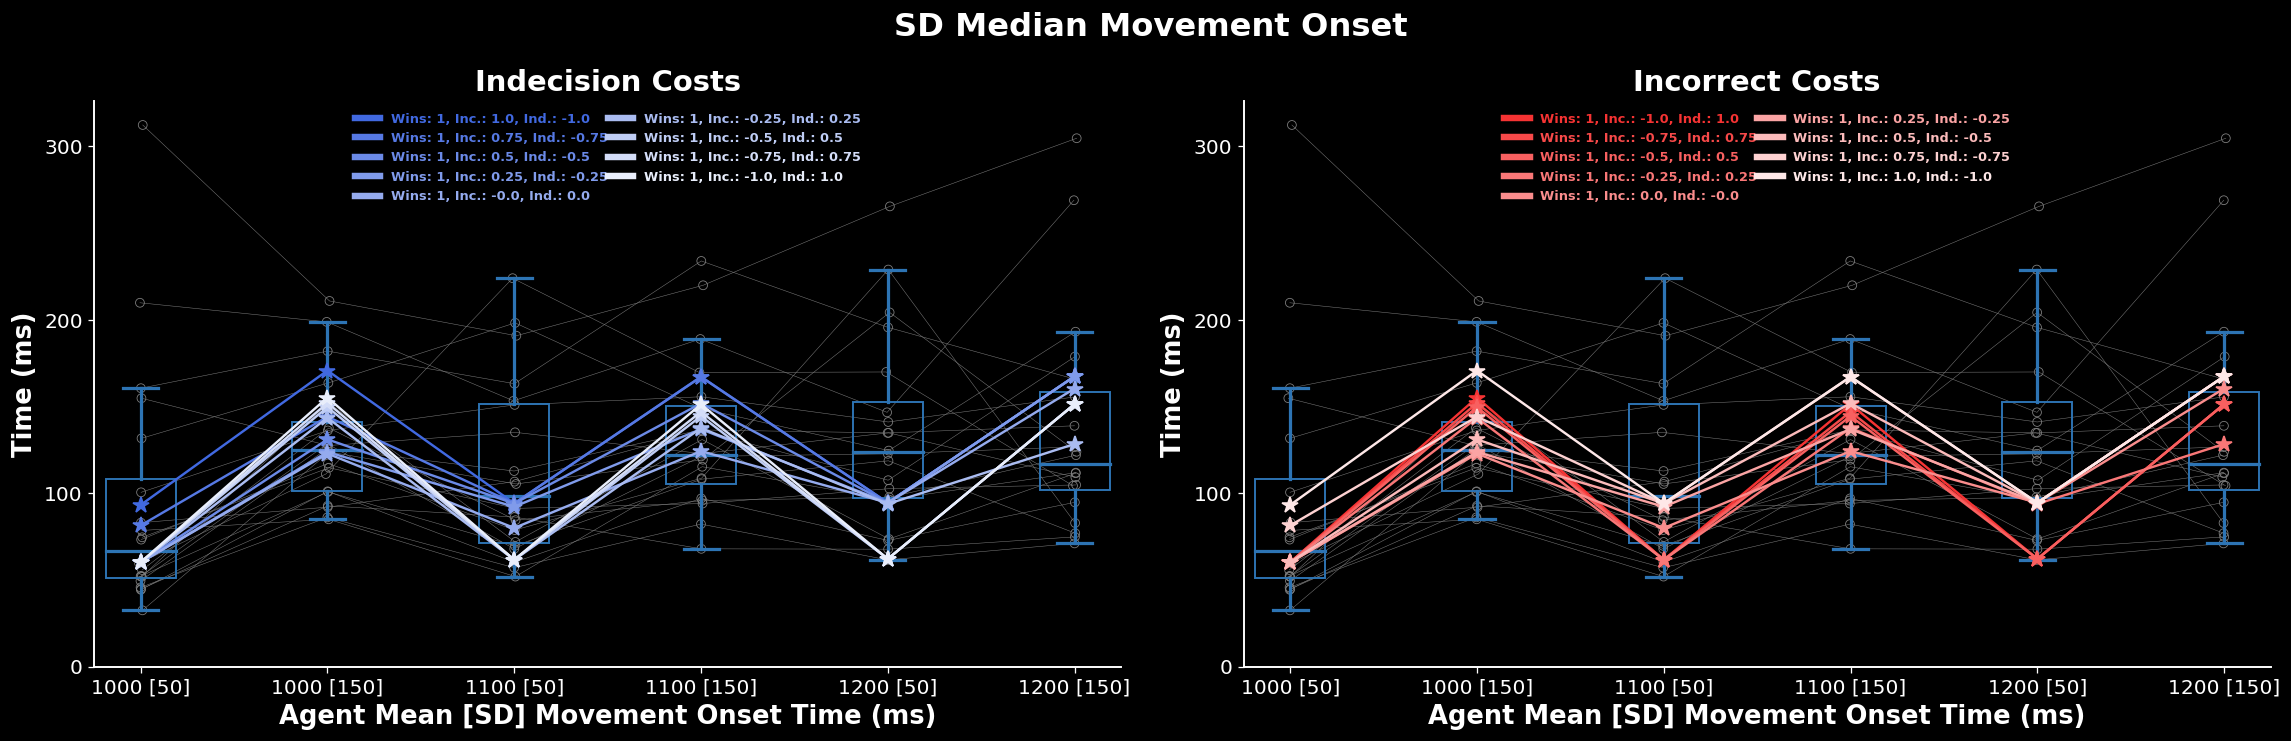

In [26]:
if True:
    metric = np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2)
    indecision_model_metrics = [model.results.get_metric(model.player_behavior.wtd_leave_time,
                                            metric_type='true', decision_type='optimal') for model in indecision_cost_models]
    incorrect_model_metrics = [model.results.get_metric(model.player_behavior.wtd_leave_time,
                                    metric_type='true', decision_type='optimal') for model in incorrect_cost_models]
    w, h = 10, 6
    fig, (ax1,ax2) = plt.subplots(1,2,dpi=116, figsize = (20,6.5))
    xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
    ylocs = np.arange(900, 1600, 100)
    pf.multiple_models_boxplot_v2(
        ax=ax1,
        data=metric,
        model_data_list=indecision_model_metrics,
        labels=indecision_cost_model_labels,
        show_boxplot=True,
        xlocs=xlocs,
        ylocs=ylocs,
        box_width=0.75,
        colors=wheel.seth_blue,
        line_colors = generate_colormap([wheel.blue,wheel.white],len(indecision_model_metrics)),
        linestyles=['-']*len(indecision_model_metrics),
        xticklabels=it.trial_block_titles,    
        xlabel= it.xlabel, 
        ylabel = "Time (ms)",
        title='Indecision Costs',    
        legend_fontsize = 8
    )
    pf.multiple_models_boxplot_v2(
        ax=ax2,
        data=metric,
        model_data_list=incorrect_model_metrics,
        labels=incorrect_cost_model_labels,
        show_boxplot=True,
        xlocs=xlocs,
        ylocs=ylocs,
        box_width=0.75,
        colors=wheel.seth_blue,
        line_colors = generate_colormap([wheel.red,wheel.white],len(indecision_model_metrics)),
        linestyles=['-']*len(indecision_model_metrics),
        xticklabels=it.trial_block_titles,    
        xlabel= it.xlabel, 
        ylabel = "Time (ms)",
        title='Incorrect Costs',
        legend_fontsize = 8
    )
    # ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
    # ax.set_ylim(600, max(ylocs))
    fig.suptitle('Median Movement Onset')
    plt.tight_layout()
    if save:
        plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
    plt.show()

##########################################
if True:
    metric = np.nanstd(group.movement_metrics.movement_onset_times('task'), axis=2)
    indecision_model_metrics = [model.results.get_metric(model.player_behavior.wtd_leave_time_sd,
                                            metric_type='true', decision_type='optimal') for model in indecision_cost_models]
    incorrect_model_metrics = [model.results.get_metric(model.player_behavior.wtd_leave_time_sd,
                                    metric_type='true', decision_type='optimal') for model in incorrect_cost_models]
    w, h = 10, 6
    fig, (ax1,ax2) = plt.subplots(1,2,dpi=116, figsize = (20,6.5))
    xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
    ylocs = np.arange(0, 400, 100)
    pf.multiple_models_boxplot_v2(
        ax=ax1,
        data=metric,
        model_data_list=indecision_model_metrics,
        labels=indecision_cost_model_labels,
        show_boxplot=True,
        xlocs=xlocs,
        ylocs=ylocs,
        box_width=0.75,
        colors=wheel.seth_blue,
        line_colors = generate_colormap([wheel.blue,wheel.white],len(indecision_model_metrics)),
        linestyles=['-']*len(indecision_model_metrics),
        xticklabels=it.trial_block_titles,    
        xlabel= it.xlabel, 
        ylabel = "Time (ms)",
        title='Indecision Costs',    
        legend_fontsize = 8
    )
    pf.multiple_models_boxplot_v2(
        ax=ax2,
        data=metric,
        model_data_list=incorrect_model_metrics,
        labels=incorrect_cost_model_labels,
        show_boxplot=True,
        xlocs=xlocs,
        ylocs=ylocs,
        box_width=0.75,
        colors=wheel.seth_blue,
        line_colors = generate_colormap([wheel.red,wheel.white],len(indecision_model_metrics)),
        linestyles=['-']*len(indecision_model_metrics),
        xticklabels=it.trial_block_titles,    
        xlabel= it.xlabel, 
        ylabel = "Time (ms)",
        title='Incorrect Costs',
        legend_fontsize = 8
    )
    # ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
    # ax.set_ylim(600, max(ylocs))
    fig.suptitle('SD Median Movement Onset')
    plt.tight_layout()
    if save:
        plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
    plt.show()

###################################
if False:
    metric = iqr(group.movement_metrics.movement_onset_times('task'), axis=2)
    indecision_model_metrics = [model.results.get_metric(model.player_behavior.wtd_leave_time_iqr,
                                            metric_type='true', decision_type='optimal') for model in indecision_cost_models]
    incorrect_model_metrics = [model.results.get_metric(model.player_behavior.wtd_leave_time_iqr,
                                    metric_type='true', decision_type='optimal') for model in incorrect_cost_models]
    w, h = 10, 6
    axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
    pf.multiple_models_boxplot_v2(
        ax=ax,
        data=metric,
        model_data_list=indecision_model_metrics,
        labels=indecision_cost_model_labels,
        show_boxplot=True,
        xlocs=np.linspace(0, w, num=len(it.trial_block_titles)),
        ylocs=np.arange(0, 400, 100),
        box_width=0.75,
        colors=wheel.seth_blue,
        linestyles=None,
        xticklabels=it.trial_block_titles,    
        xlabel= it.xlabel, 
        ylabel = "Time (ms)",
        title = "IQR Movement Onset Time"    
    )
    # ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
    # ax.set_ylim(600, max(ylocs))
    if save:
        plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
    axmain.set_axis_off()
    plt.show()

Wins


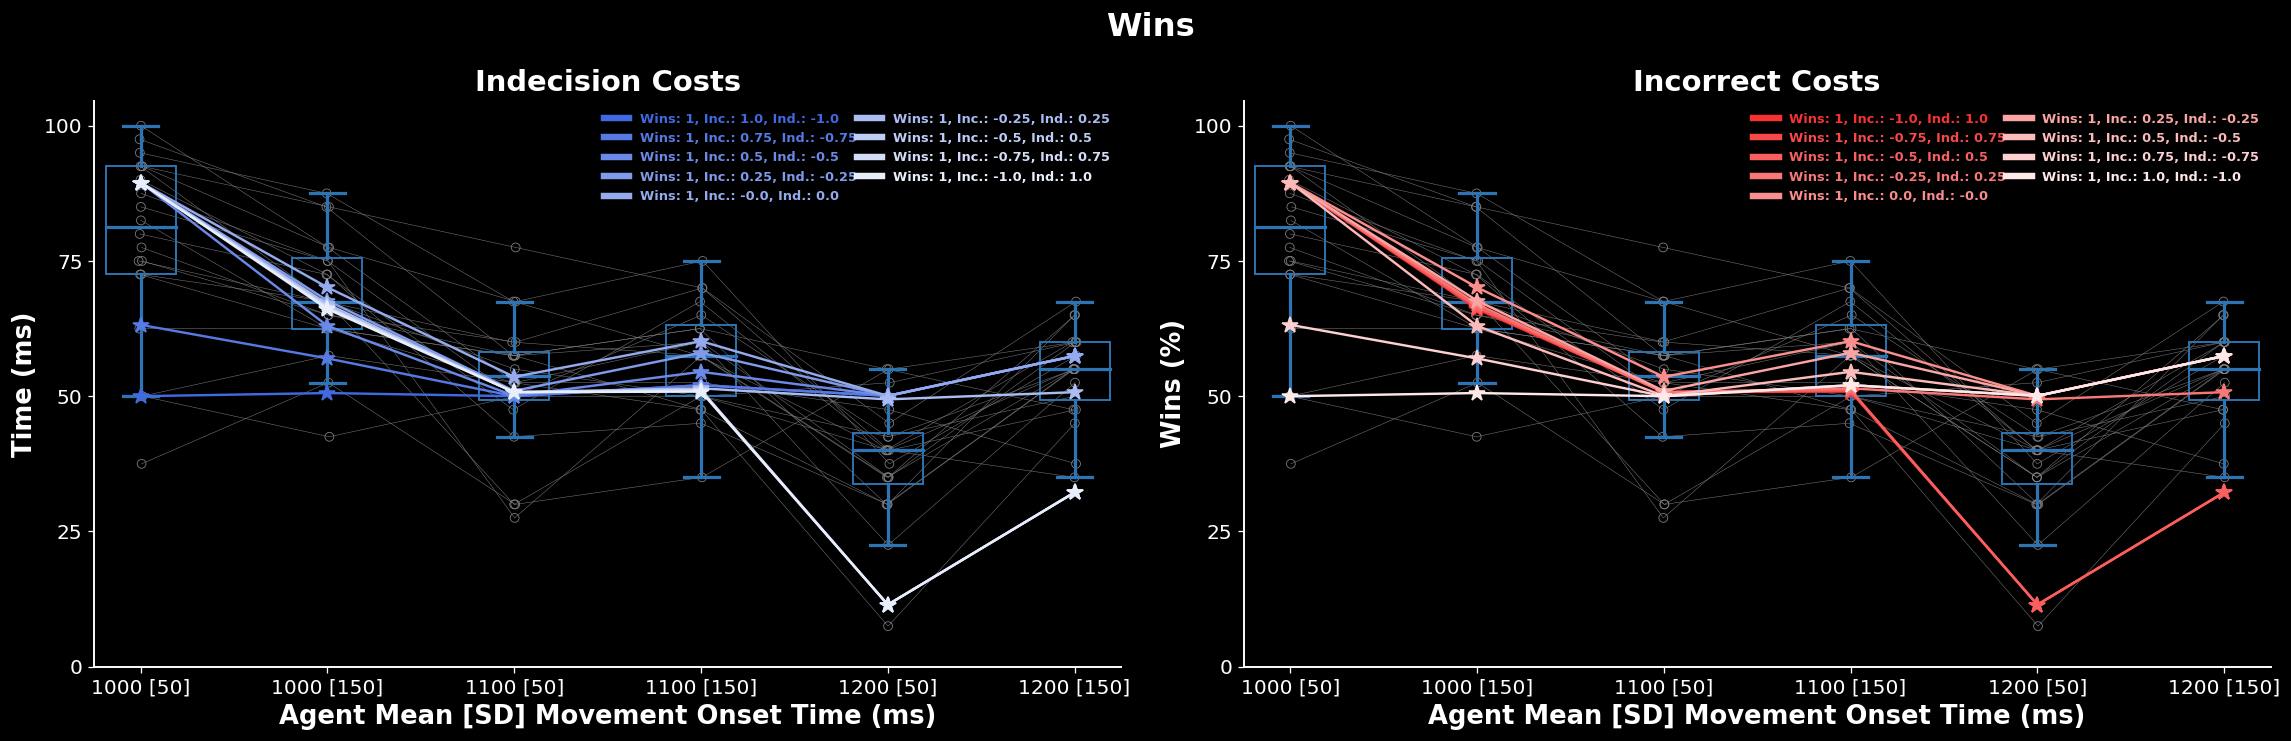

In [27]:
metric = group.score_metrics.score_metric('wins')/group.exp_info.num_task_trials*100
indecision_model_metrics = [model.results.get_metric(model.score_metrics.prob_win,
                                            metric_type='true', decision_type='optimal')*100 for model in indecision_cost_models]
incorrect_model_metrics = [model.results.get_metric(model.score_metrics.prob_win,
                                    metric_type='true', decision_type='optimal')*100 for model in incorrect_cost_models]
w, h = 10, 6
fig, (ax1,ax2) = plt.subplots(1,2,dpi=116, figsize = (20,6.5))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 101, 25)
pf.multiple_models_boxplot_v2(
    ax=ax1,
    data=metric,
    model_data_list=indecision_model_metrics,
    labels=indecision_cost_model_labels,
    show_boxplot=True,
    xlocs=xlocs,
    ylocs=ylocs,
    box_width=0.75,
    colors=wheel.seth_blue,
    line_colors = generate_colormap([wheel.blue,wheel.white],len(indecision_model_metrics)),
    linestyles=['-']*len(indecision_model_metrics),
    xticklabels=it.trial_block_titles,    
    xlabel= it.xlabel, 
    ylabel = "Time (ms)",
    title='Indecision Costs',    
    legend_fontsize = 8
)
pf.multiple_models_boxplot_v2(
    ax=ax2,
    data=metric,
    model_data_list=incorrect_model_metrics,
    labels=incorrect_cost_model_labels,
    show_boxplot=True,
    xlocs=xlocs,
    ylocs=ylocs,
    box_width=0.75,
    colors=wheel.seth_blue,
    line_colors = generate_colormap([wheel.red,wheel.white],len(indecision_model_metrics)),
    linestyles=['-']*len(indecision_model_metrics),
    xticklabels=it.trial_block_titles,    
    xlabel= it.xlabel, 
    ylabel = "Wins (%)",
    title='Incorrect Costs',
    legend_fontsize = 8
)
# ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
# ax.set_ylim(600, max(ylocs))
fig.suptitle('Wins')
plt.tight_layout()
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
plt.show()

Points


In [28]:
if experiment == "Exp2":
    metric = group.player_points_scored
    true_player_metric = get_true_metric(model_known_switch.expected_reward.exp_reward, metric_type="fit") * group.num_task_trials[0]
    exp_player_metric = get_exp_metric(model_unknown.expected_reward.exp_reward, metric_type="fit") * group.num_task_trials[0]
    true_optimal_metric = get_true_metric(model_known_switch.expected_reward.exp_reward, metric_type="optimal") * group.num_task_trials[0]
    exp_optimal_metric = get_exp_metric(model_known_switch.expected_reward.exp_reward, metric_type="optimal") * group.num_task_trials[0]
    w, h = 10, 6
    axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
    xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
    ylocs = np.arange(0, 125, 20)

    bw = 0.75
    pf.multiple_models_boxplot(
        ax,
        metric,
        true_player=true_player_metric,
        expected_player=exp_player_metric,
        true_optimal=true_optimal_metric,
        expected_optimal=exp_optimal_metric,
        xlocs=xlocs,
        box_width=bw,
        colors=wheel.seth_blue,
        remove_parentheses_from_labels=False,
    )

    ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
    ax.set_xticks(xlocs), ax.set_yticks(ylocs)
    ax.set_xticklabels(it.trial_block_titles)
    ax.set_ylim(-20, 80)
    ax.set_xlabel(it.xlabel)
    ax.set_ylabel("Points Scored")
    # dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

    if save:
        axmain.set_axis_off()
        plt.savefig(SAVE_PATH + "incorrects_with_optimal_model", dpi=400, transparent=True)
    axmain.set_axis_off()

    plt.show()

Incorrects


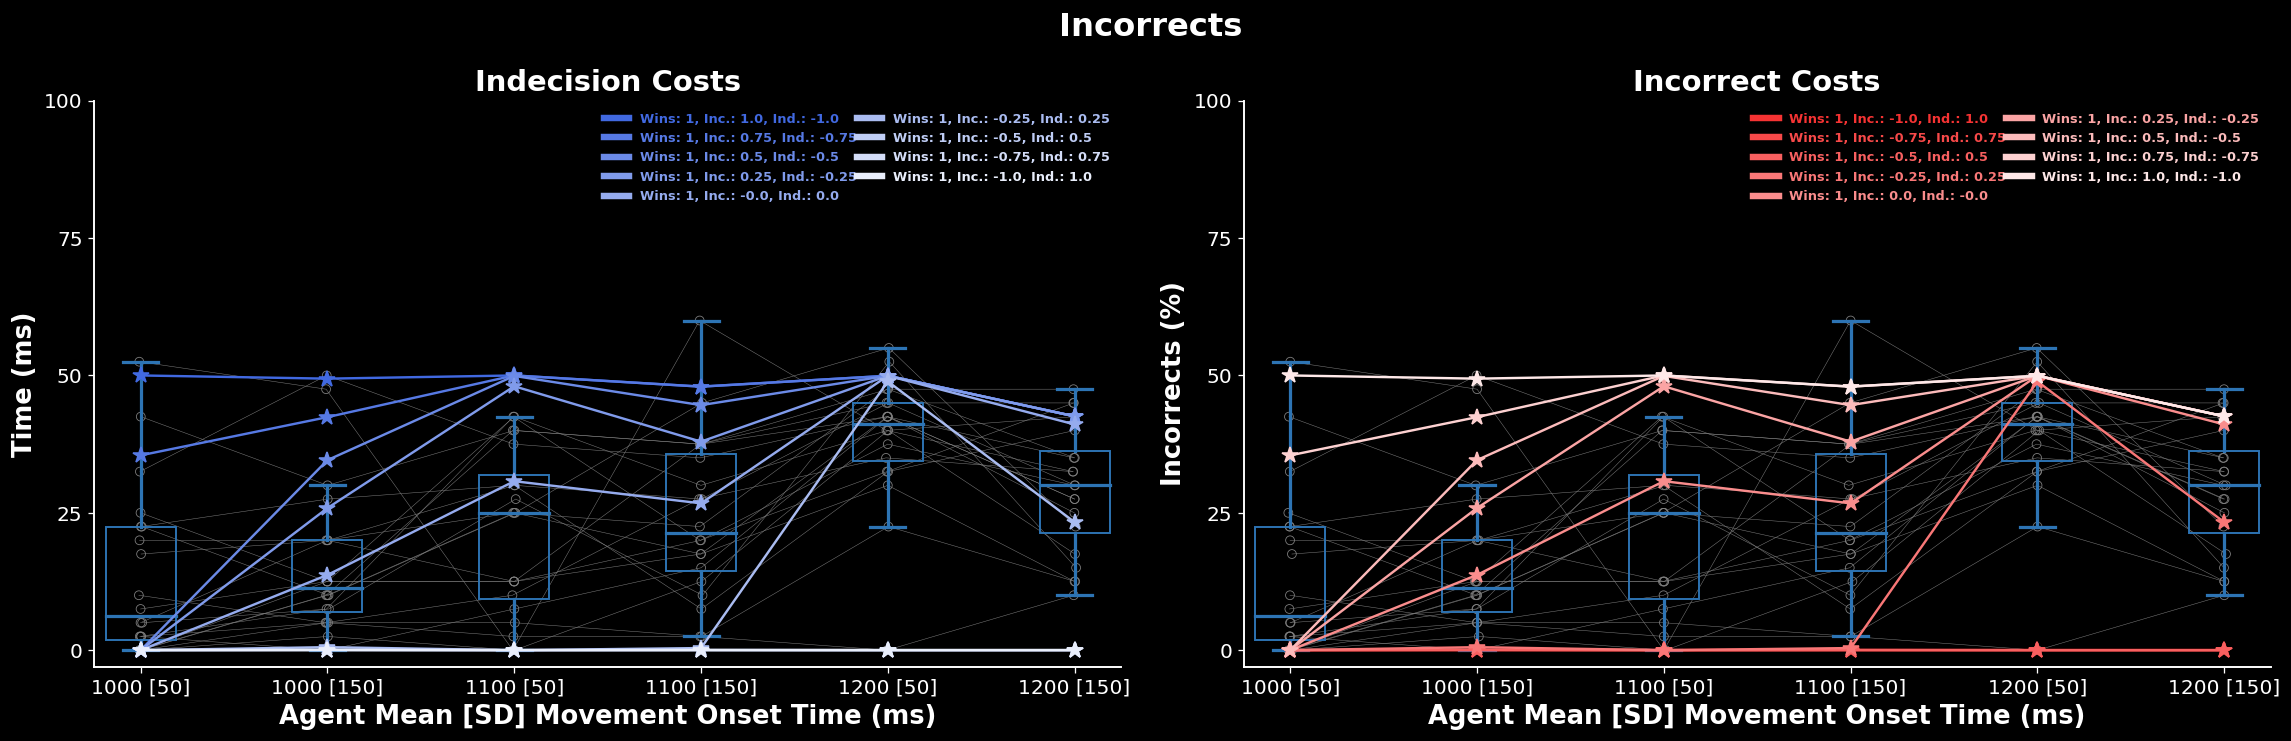

In [29]:
metric = group.score_metrics.score_metric('incorrects')/group.exp_info.num_task_trials*100
indecision_model_metrics = [model.results.get_metric(model.score_metrics.prob_incorrect,
                                            metric_type='true', decision_type='optimal')*100 for model in indecision_cost_models]
incorrect_model_metrics = [model.results.get_metric(model.score_metrics.prob_incorrect,
                                    metric_type='true', decision_type='optimal')*100 for model in incorrect_cost_models]
w, h = 10, 6
fig, (ax1,ax2) = plt.subplots(1,2,dpi=116, figsize = (20,6.5))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 101, 25)
pf.multiple_models_boxplot_v2(
    ax=ax1,
    data=metric,
    model_data_list=indecision_model_metrics,
    labels=indecision_cost_model_labels,
    show_boxplot=True,
    xlocs=xlocs,
    ylocs=ylocs,
    box_width=0.75,
    colors=wheel.seth_blue,
    line_colors = generate_colormap([wheel.blue,wheel.white],len(indecision_model_metrics)),
    linestyles=['-']*len(indecision_model_metrics),
    xticklabels=it.trial_block_titles,    
    xlabel= it.xlabel, 
    ylabel = "Time (ms)",
    title='Indecision Costs',    
    legend_fontsize = 8
)
pf.multiple_models_boxplot_v2(
    ax=ax2,
    data=metric,
    model_data_list=incorrect_model_metrics,
    labels=incorrect_cost_model_labels,
    show_boxplot=True,
    xlocs=xlocs,
    ylocs=ylocs,
    box_width=0.75,
    colors=wheel.seth_blue,
    line_colors = generate_colormap([wheel.red,wheel.white],len(indecision_model_metrics)),
    linestyles=['-']*len(indecision_model_metrics),
    xticklabels=it.trial_block_titles,    
    xlabel= it.xlabel, 
    ylabel = "Incorrects (%)",
    title='Incorrect Costs',
    legend_fontsize = 8
)
# ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
# ax.set_ylim(600, max(ylocs))
fig.suptitle('Incorrects')
plt.tight_layout()
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
plt.show()

Indecisions


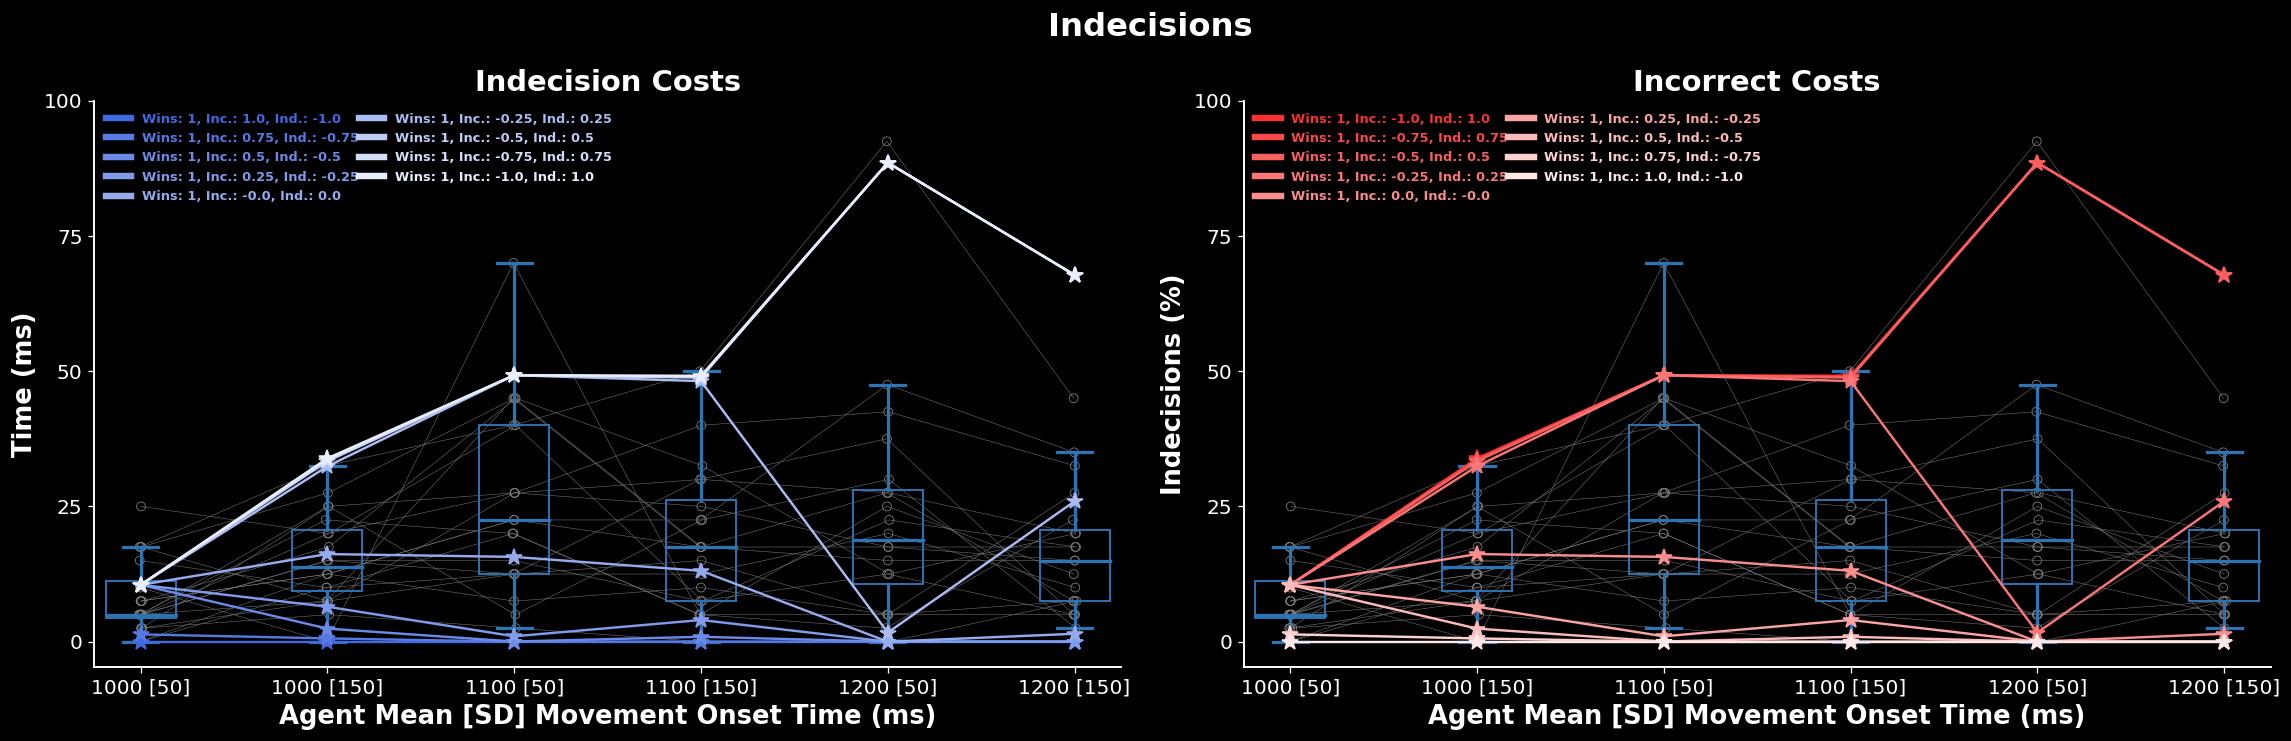

In [30]:
metric = group.score_metrics.score_metric('indecisions')/group.exp_info.num_task_trials*100
indecision_model_metrics = [model.results.get_metric(model.score_metrics.prob_indecision,
                                            metric_type='true', decision_type='optimal')*100 for model in indecision_cost_models]
incorrect_model_metrics = [model.results.get_metric(model.score_metrics.prob_indecision,
                                    metric_type='true', decision_type='optimal')*100 for model in incorrect_cost_models]
w, h = 10, 6
fig, (ax1,ax2) = plt.subplots(1,2,dpi=116, figsize = (20,6.5))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 101, 25)
pf.multiple_models_boxplot_v2(
    ax=ax1,
    data=metric,
    model_data_list=indecision_model_metrics,
    labels=indecision_cost_model_labels,
    show_boxplot=True,
    xlocs=xlocs,
    ylocs=ylocs,
    box_width=0.75,
    colors=wheel.seth_blue,
    line_colors = generate_colormap([wheel.blue,wheel.white],len(indecision_model_metrics)),
    linestyles=['-']*len(indecision_model_metrics),
    xticklabels=it.trial_block_titles,    
    xlabel= it.xlabel, 
    ylabel = "Time (ms)",
    title='Indecision Costs',    
    legend_fontsize = 8
)
pf.multiple_models_boxplot_v2(
    ax=ax2,
    data=metric,
    model_data_list=incorrect_model_metrics,
    labels=incorrect_cost_model_labels,
    show_boxplot=True,
    xlocs=xlocs,
    ylocs=ylocs,
    box_width=0.75,
    colors=wheel.seth_blue,
    line_colors = generate_colormap([wheel.red,wheel.white],len(indecision_model_metrics)),
    linestyles=['-']*len(indecision_model_metrics),
    xticklabels=it.trial_block_titles,    
    xlabel= it.xlabel, 
    ylabel = "Indecisions (%)",
    title='Incorrect Costs',
    legend_fontsize = 8
)
# ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
# ax.set_ylim(600, max(ylocs))
fig.suptitle('Indecisions')
plt.tight_layout()
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
plt.show()

Correct Initial Decisions


In [31]:
metric = perc(group.movement_metrics.correct_initial_decisions)

no_switch_metric = get_no_switch_metric(model_no_switch.score_metrics.correct_decisions,decision_type='optimal')*100
known_switch_sd_neither_metric   = get_known_switch_sd_neither_metric(model_known_switch_sd_neither.score_metrics.correct_decisions,
                                                                        metric_type='true', decision_type='optimal')*100 
known_switch_sd_both_metric      = get_known_switch_sd_both_metric(model_known_switch_sd_both.score_metrics.correct_decisions,
                                                                        metric_type='true', decision_type='optimal')*100 
known_switch_sd_fit_metric       = get_known_switch_sd_fit_metric(model_known_switch_sd_fit.score_metrics.correct_decisions,
                                                                        metric_type='true', decision_type='optimal')*100 
known_switch_sd_loss_metric      = get_known_switch_sd_loss_metric(model_known_switch_sd_loss.score_metrics.correct_decisions,
                                                                        metric_type='true', decision_type='optimal')*100
unknown_switch_sd_neither_metric = get_unknown_switch_sd_neither_metric(model_unknown_switch_sd_neither.score_metrics.correct_decisions,
                                                                        metric_type='true', decision_type='optimal')*100 
unknown_switch_sd_both_metric    = get_unknown_switch_sd_both_metric(model_unknown_switch_sd_both.score_metrics.correct_decisions,
                                                                        metric_type='true', decision_type='optimal')*100 
unknown_switch_sd_fit_metric     = get_unknown_switch_sd_fit_metric(model_unknown_switch_sd_fit.score_metrics.correct_decisions,
                                                                        metric_type='true', decision_type='optimal')*100 
unknown_switch_sd_loss_metric    = get_unknown_switch_sd_loss_metric(model_unknown_switch_sd_loss.score_metrics.correct_decisions,
                                                                        metric_type='true', decision_type='optimal')*100 
known_models = [known_switch_sd_neither_metric, known_switch_sd_both_metric, known_switch_sd_fit_metric, known_switch_sd_loss_metric,]
unknown_models = [unknown_switch_sd_neither_metric, unknown_switch_sd_both_metric, unknown_switch_sd_fit_metric, unknown_switch_sd_loss_metric,]
models = known_models+unknown_models
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=metric,
    model_data_list=models,
    labels=all_model_labels,
    show_boxplot=True,
    xlocs=np.linspace(0, w, num=len(it.trial_block_titles)),
    ylocs=np.arange(0, 101, 25),
    box_width=0.75,
    colors=wheel.seth_blue,
    linestyles=None,
    xticklabels=it.trial_block_titles,    
    xlabel= it.xlabel, 
    ylabel = "Correct Decisions (%)",
    title = None    
)
# ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
# ax.set_ylim(600, max(ylocs))
if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "correct_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

NameError: name 'get_no_switch_metric' is not defined